# Viscoelastic Earthquake Cycles (semi-analytical solve)
In this notebook we will show how we can exploit boundary element calculations to run viscoelastic earthquake calculations. The premise is that once we construct a stress interaction kernel i.e., a function that relates slip on any point on a fault or inelastic strain at any location in the viscoelastic bulk to stress change everywhere else, all the expensive computations are done. Such an approach works because we have assumed rheologies where strains are additive i.e., 
$$
\epsilon = \epsilon_e + \epsilon_v
$$
where $\epsilon_e$ is the elastic component and $\epsilon_v$ is the inelastic component, in this case we choose a viscous term.

For a linear viscoelastic spring-dashpot system, the stress is common to the elastic and viscous elements,
$$
\sigma = \mu\epsilon_e = \eta\dot{\epsilon}_v
$$
which can be differentiated w.r.t time to give us the governing ordinary differential equation (ODE) for the system: $\mu\left(\dot{\epsilon} - \dot{\epsilon}_v\right) = \eta\frac{\mathrm{d}\dot{\epsilon}_v}{\mathrm{d}t}$. In the case of a tectonic plate boundary we know it is driven in the long-term by plate driving forces that result in  long-term viscous strain $\dot{\epsilon}^{\infty}$. Substituting this gives us,
$$
\mu\left(\dot{\epsilon}^{\infty} - \dot{\epsilon}_v\right) = \eta\frac{\mathrm{d}\dot{\epsilon}_v}{\mathrm{d}t}
$$

The role of the stress interaction kernel is highlighted when we bring in physical dimensions to the problem. Due to the non-local nature of elastic interactions, we need to replace the elastic modulus $\mu$ with $K(x_o;x_s)$ where $x_o,x_s$ are observation and source location combinations respectively. Instead of an ODE, we now have a coupled system of ODEs
$$
\frac{\mathrm{d}\dot{\epsilon}_v}{\mathrm{d}t} = \frac{K}{\eta}\left(\dot{\epsilon}^{\infty} - \dot{\epsilon}_v\right).
$$
subject to $\dot{\epsilon}_v(t = 0)$. This system of equations can be solved semi-analytically using an eigen decomposition of $\frac{K}{\eta} = T\Lambda T^{-1}$, which gives
$$
\dot{\epsilon}_v = T e^{\Lambda t} T^{-1}\dot{\epsilon}_v(0)
$$

In [1]:
clear  
addpath functions/
import('geometry.*')

% Elastic parameters (homogenous medium)
nu=0.25;% Poisson's ratio
mu=30e3;% in MPa

% Periodic earthquake recurrence time
Trecur = 500*3.15e7;% in seconds
Vpl = 1e-9;% m/s

% max stress change on fault (MPa)
tau_max = 3;

In [2]:
%% load fault, boundary and shear zone meshes
earthModel = geometry.LDhs(mu,nu);

rcv = geometry.receiver('inputs/megathrust2d.seg',earthModel);

% boundary mesh
boundary = geometry.receiver('inputs/boundary2d.seg',earthModel);
boundary.Vx = boundary.Vx.*Vpl;
boundary.Vz = boundary.Vz.*Vpl;

% provide shear zone mesh as 2 .dat files of the form
% meshname_vertices.dat (contains x,z coordinates of vertices)
% meshname_triangulation.dat (contains 3 columns of vertex linkage)
% This mesh can be created using CREATE_shearzone_mesh.m provided in the
% folder 'meshing'

shz = geometry.shearZoneReceiver('inputs/shearzone',earthModel);

%% compute stress interaction kernels
% evl contains the following as N-d matrices
% KK - fault-fault interactions [rcv.N x rcv.N]
% KL - fault-shz interactions [shz.N x rcv.N x 2]
% LK - shz-fault interactions [rcv.N x shz.N x 2]
% LL - shz-shz interactions [shz.N x shz.N x 2 x 2]

% use unmodified kernels for this solve
if exist('kernels/evl_orig.mat') % load kernels if they exist    
    load('kernels/evl_orig.mat','evl_orig');
else
    evl_orig = computeAllStressKernelsBem(rcv,shz,boundary,'kernelmodify',0);
end
% compute displacement kernels
Nobs = 401;
obs = ([1;0]*(linspace(-100,500,Nobs)))'*1e3;
if exist('kernels/devl.mat')
    load('kernels/devl.mat','devl');
else
    devl = computeAllDisplacementKernelsBem(obs,rcv,shz,boundary,1);
end


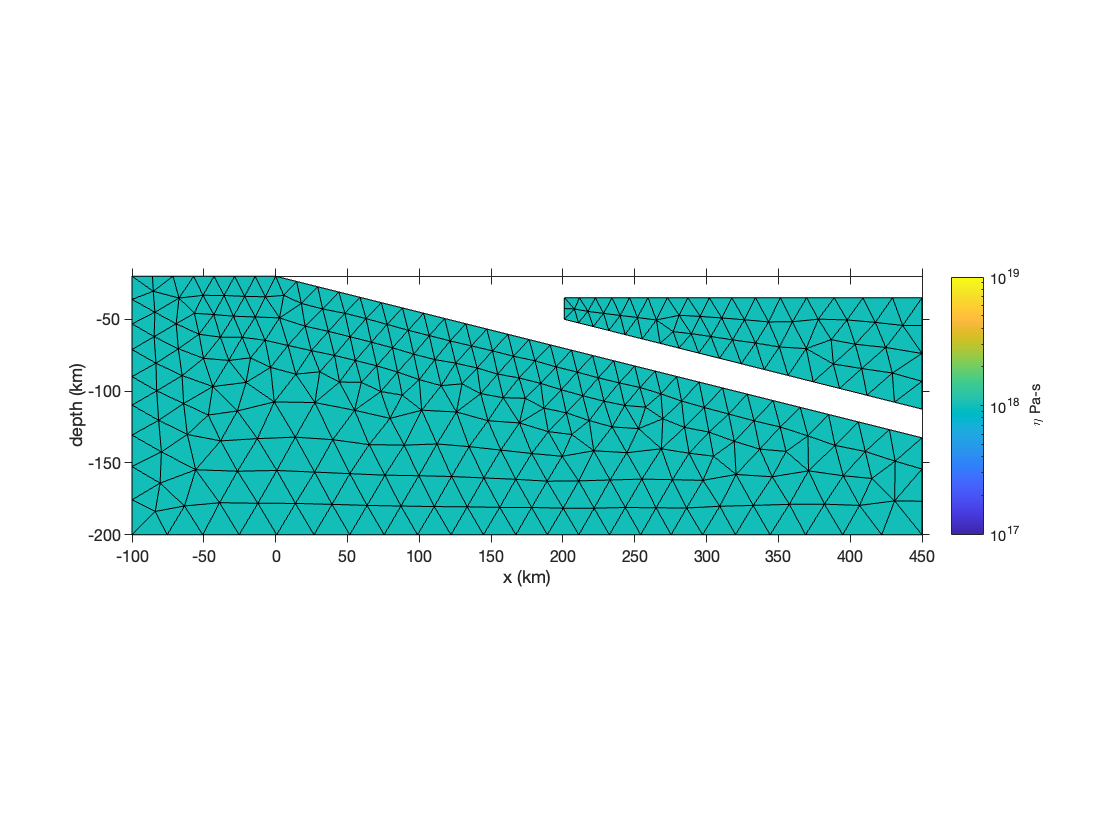

In [6]:
%% assign rheological properties 

%%%%%%% approximate fault by a viscous shear zone %%%%%%%
% (a-b)sigma in terms of viscosity
% eta' = viscosity/L_fault
rcv.Asigma = 1e-6.*(1e21/(sum(~rcv.pinnedPosition.*rcv.W))).*ones(rcv.N,1);

%%%%%%% oceanic mantle viscosity structure %%%%%%%
r = abs(tand(rcv.dip(1)).*shz.xc(:,1) + shz.xc(:,2) + 20e3)./sqrt(tand(rcv.dip(1))^2 + 1);
r = r./max(r);% normalize to 0->1
viscostructure = 10.^(18 + r.*0);
shz.n = 1.*ones(shz.N,1);
shz.alpha = 1./(viscostructure.*1e-6);
oceanic_mantle = (shz.xc(:,1) < -shz.xc(:,2)/tand(rcv.dip(1)));

%%%%%%% continental mantle viscosity structure %%%%%%%
r = sqrt((shz.xc(~oceanic_mantle,1)-200e3).^2);
r = r./max(r);% normalize to 0->1
viscostructure = 10.^(18 + r.*0);
shz.alpha(~oceanic_mantle) = 1./(viscostructure.*1e-6);

% define locked zone on megathrust
locked = abs(rcv.xc(:,2)) > 0e3 & abs(rcv.xc(:,2))< 30e3;
rcv.pinnedPosition = locked;

% define long-term slip/strain rates
rcv.Vpl = Vpl.*ones(rcv.N,1);% m/s

% compute steady state interseismic slip rate & strain rates
[v_ss,e22_ss,e23_ss] = computeInterseismicSteadystate(rcv,shz,evl_orig,Vpl,10);

% Long-term strain rate calculation
[e22_dev_lt, e23_lt] = getStrainratesLongterm(shz,rcv.dip(1)*pi/180,[0,20e3],[-140e3,35e3]);
shz.e22pl = e22_dev_lt.*Vpl;% 1/s
shz.e23pl = -e23_lt.*Vpl;% 1/s

figure(1),clf
plotshz2d(shz,1e6./(shz.alpha))
axis tight equal, box on
cb=colorbar; cb.Label.String = '\eta Pa-s';
xlabel('x (km)'), ylabel('depth (km)')
set(gca,'ColorScale','log','FontSize',8,'LineWidth',0.5,'TickDir','both')

In [4]:
%% calculate coseismic stress change - imposed periodically
Nevents = 1;
slip_coseismic = zeros(rcv.N,Nevents) + Trecur*Vpl.*(locked);

% initialise stress change data structure
stress_change = [];
stress_change.Nevents = Nevents;
stress_change.Timing = 1;
assert(length(stress_change.Timing) == Nevents)

stress_change.dtau = zeros(rcv.N,stress_change.Nevents);
stress_change.dsigma22 = zeros(shz.N,stress_change.Nevents);
stress_change.dsigma23 = zeros(shz.N,stress_change.Nevents);

% stress change for each event stored as a matrix
for i = 1:stress_change.Nevents
    dtau = evl_orig.KK*slip_coseismic(:,i);
    dtau(dtau > tau_max) = tau_max;
    stress_change.dtau(:,i) = dtau;
    stress_change.dtau(locked,i) = 0;% force stress change in coseismic region to 0

    stress_change.dsigma22(:,i) = evl_orig.KL(:,:,1)*slip_coseismic(:,i);
    stress_change.dsigma23(:,i) = evl_orig.KL(:,:,2)*slip_coseismic(:,i);
end

In [4]:
%% construct stress interaction kernel (use unmodified stress kernel for interseismic calculation)
stresskernel = [evl_orig.KK(~locked,~locked),  evl_orig.LK(~locked,:,1),   evl_orig.LK(~locked,:,2);...
                     evl_orig.KL(:,~locked,1),      evl_orig.LL(:,:,1,1),       evl_orig.LL(:,:,1,2);...
                     evl_orig.KL(:,~locked,2),      evl_orig.LL(:,:,2,1),       evl_orig.LL(:,:,2,2)];

viscosityvector = [rcv.Asigma(~locked);1./shz.alpha;1./shz.alpha];
Nvec = length(viscosityvector);

rheoparam = stresskernel./repmat(viscosityvector,1,Nvec);

% eigenvector decomposition
[Evector,Evals] = eig(rheoparam);
% store eigenvalues in a vector
lambda = diag(Evals);
lambda_positive = (real(lambda) >= 0);
lambda(lambda_positive) = -Inf;

% combine all stress change into a single vector that captures coseismic
% strain rate change
deltastrainrate = [stress_change.dtau(~locked);stress_change.dsigma22;stress_change.dsigma23]./viscosityvector;

% long-term steady state strain rates
longterm_ss = [v_ss(~locked);e22_ss;e23_ss];

%% compute late interseismic strain rates and initial conditions
% compute late-interseismic strain rate
sol_interseismic = real((eye(Nvec) - Evector*diag(exp(lambda.*Trecur))/Evector)\...
            (Evector*diag(exp(lambda.*Trecur))/Evector*(deltastrainrate-longterm_ss) + longterm_ss));


sol_initial = sol_interseismic + deltastrainrate;

%% evaluate slip/strain at various times

% tvec = [30,365,5*365].*86400;% seconds
% tvec = [5,10,15,20,50,100].*3.15e7;
tvec = [[10,365,1500].*86400, Trecur];

slip = zeros(rcv.N,length(tvec));
e22 = zeros(shz.N,length(tvec));
e23 = zeros(shz.N,length(tvec));

V = zeros(rcv.N,length(tvec));
e22dot = zeros(shz.N,length(tvec));
e23dot = zeros(shz.N,length(tvec));

for i = 1:length(tvec)
    tval = tvec(i);
    % time-integrate dynammics
    sol = real(Evector*diag(exp(lambda.*tval))/Evector*(sol_initial-sol_interseismic)) + ...
               sol_interseismic;
    % extract solution to velocity & strainrate components
    V(~locked,i) = sol(1:length(find(~locked)));
    e22dot(:,i) = sol(length(find(~locked))+1:length(find(~locked))+shz.N);
    e23dot(:,i) = sol(length(find(~locked))+shz.N+1:end);

    % double integrated
    lambda_integrated = (exp(lambda.*tval) - ones(Nvec,1))./lambda;
    lambda_integrated(lambda_positive) = 0;
    sol = real(Evector*diag(lambda_integrated)/Evector*(sol_initial-sol_interseismic)) + ...
               sol_interseismic.*tval;
    
    % extract solution to slip & strain components
    slip(~locked,i) = sol(1:length(find(~locked)));
    e22(:,i) = sol(length(find(~locked))+1:length(find(~locked))+shz.N);
    e23(:,i) = sol(length(find(~locked))+shz.N+1:end);
end

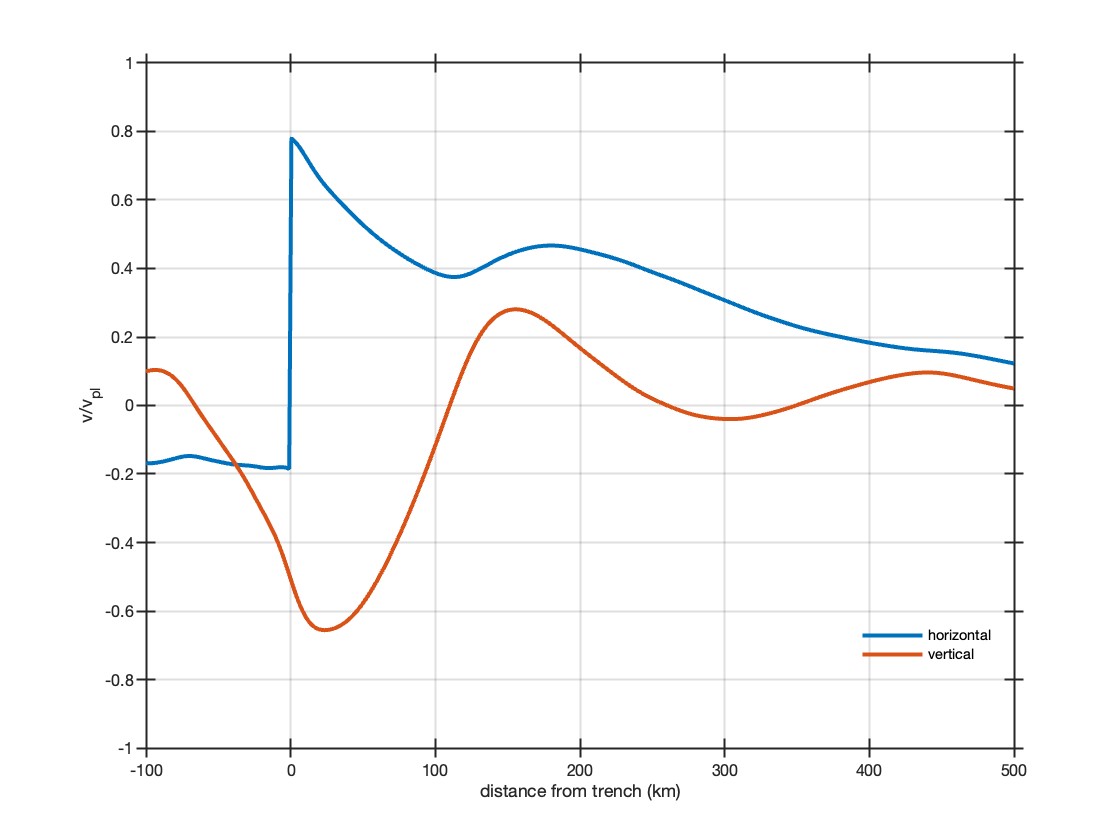

In [9]:
%% surface displacements and velocities
% calculate displacement time series at select observation points

hinge = geometry.receiver('inputs/hinge2d.seg',earthModel);
[Gx_d,Gz_d] = computeFaultDisplacementKernelsBem(hinge,obs,boundary,1);

fullsol_interseismic = [zeros(length(find(locked)),1);sol_interseismic] - [rcv.Vpl;shz.e22pl;shz.e23pl];
vx_int = [devl.KO(:,:,1),devl.LO(:,:,1,1),devl.LO(:,:,1,2)]*fullsol_interseismic - Gx_d * (hinge.Vpl.*Vpl); 
vz_int = [devl.KO(:,:,2),devl.LO(:,:,2,1),devl.LO(:,:,2,2)]*fullsol_interseismic - Gz_d * (hinge.Vpl.*Vpl); 

figure(1),clf
plot(obs(:,1)./1e3,vx_int./Vpl,'LineWidth',2), hold on
plot(obs(:,1)./1e3,vz_int./Vpl,'LineWidth',2)
axis tight,grid on
ylim([-1 1])
legend('horizontal','vertical','Box','off','Location','best')
xlabel('distance from trench (km)'), ylabel('v/v_{pl}')
set(gca,'FontSize',8,'LineWidth', 1,'TickDir','both')

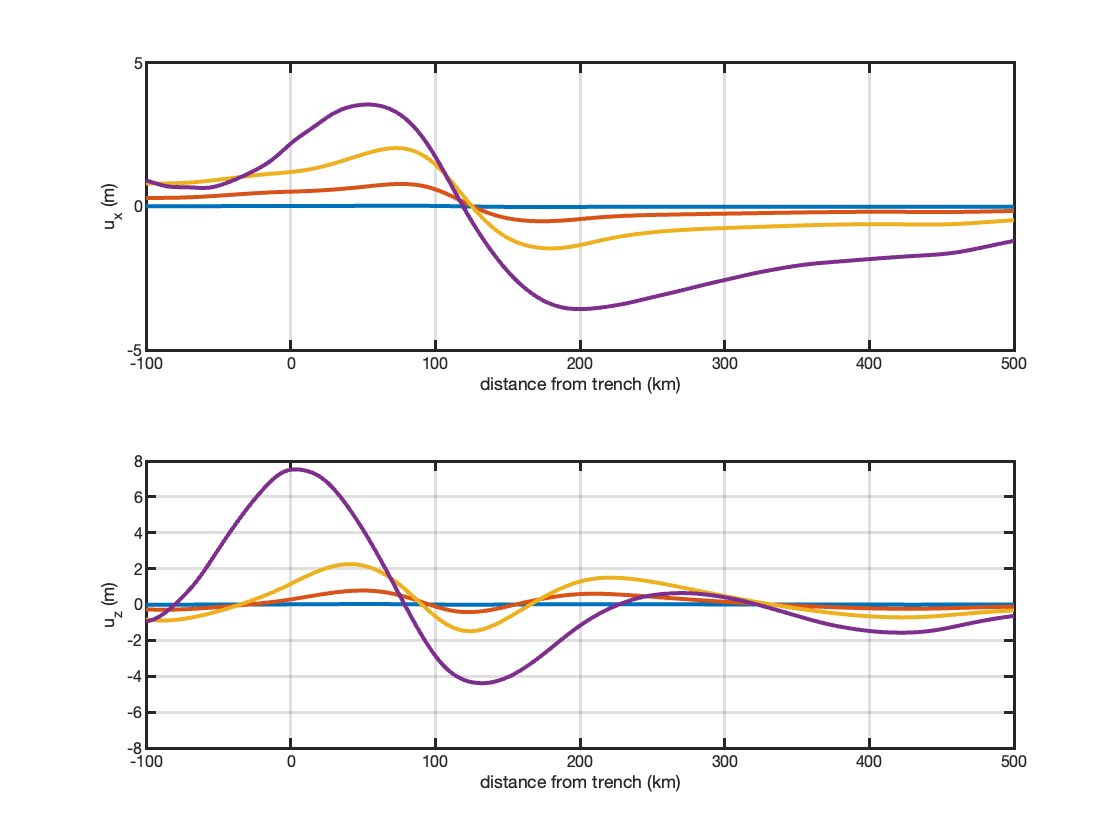

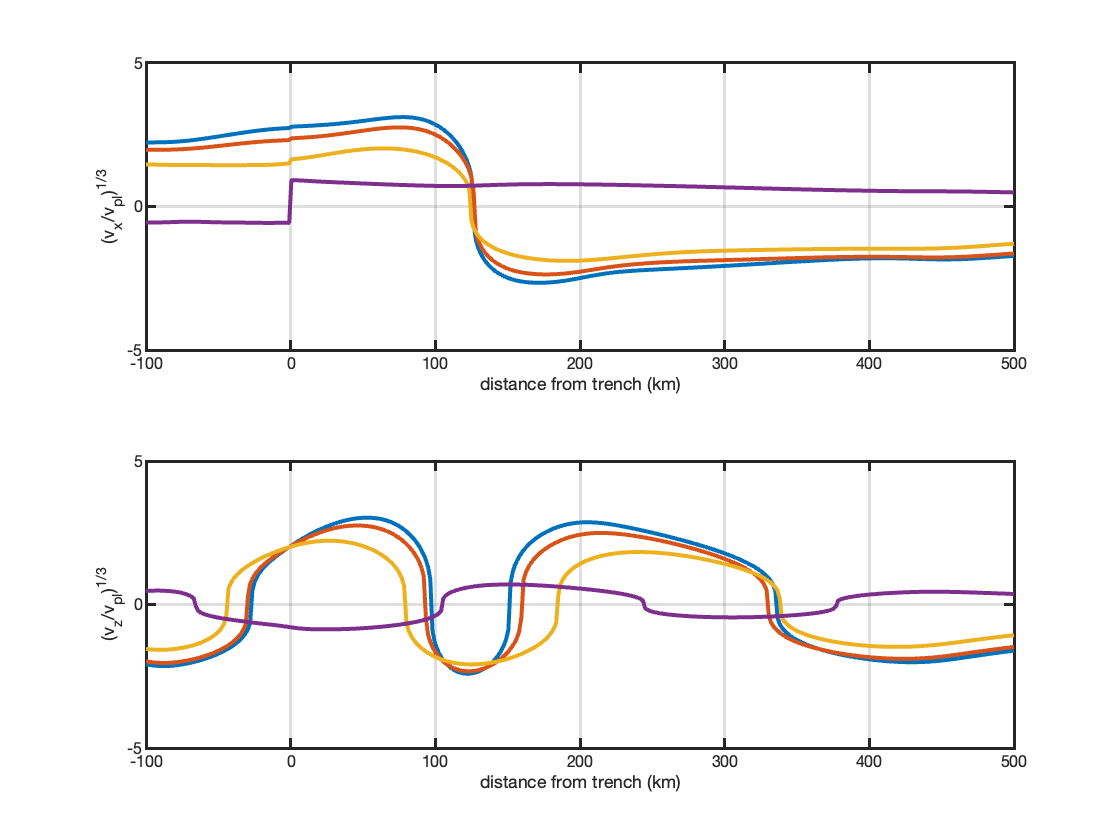

In [12]:
gps = [];
gps.obs = obs;
gps.vx = (devl.KO(:,:,1)*(V-rcv.Vpl) + ...
          devl.LO(:,:,1,1)*(e22dot-shz.e22pl) + ... 
          devl.LO(:,:,1,2)*(e23dot-shz.e23pl) - ...
          Gx_d*(hinge.Vpl.*Vpl))';
gps.vz = (devl.KO(:,:,2)*(V-rcv.Vpl) + ...
          devl.LO(:,:,2,1)*(e22dot-shz.e22pl) + ...
          devl.LO(:,:,2,2)*(e23dot-shz.e23pl) - ...
          Gz_d*(hinge.Vpl.*Vpl))';

gps.ux = (devl.KO(:,:,1)*(slip-rcv.Vpl*tvec) + ...
          devl.LO(:,:,1,1)*(e22-shz.e22pl*tvec) + ... 
          devl.LO(:,:,1,2)*(e23-shz.e23pl*tvec) - ...
          1.*Gx_d * (hinge.Vpl.*Vpl)*tvec)';
gps.uz = (devl.KO(:,:,2)*(slip-rcv.Vpl*tvec) + ...
          devl.LO(:,:,2,1)*(e22-shz.e22pl*tvec) + ...
          devl.LO(:,:,2,2)*(e23-shz.e23pl*tvec) - ...
          1.*Gz_d * (hinge.Vpl.*Vpl)*tvec)';

% postseismic displacements (interseismic corrected)
figure(13),clf
subplot(2,1,1)
plot(obs(:,1)./1e3,nthroot(gps.ux' - vx_int*tvec,1),'LineWidth',2)
axis tight, grid on
ylim([-1 1]*5)
xlabel('distance from trench (km)')
ylabel('u_x (m)')
set(gca,'FontSize',8,'LineWidth',1.5)
subplot(2,1,2)
plot(obs(:,1)./1e3,nthroot(gps.uz' - vz_int*tvec,1),'LineWidth',2)
axis tight, grid on
ylim([-1 1]*8)
xlabel('distance from trench (km)')
ylabel('u_z (m)')
set(gca,'FontSize',8,'LineWidth',1.5)

% postseismic velocity snapshots (plotted as cube root to retain sign and compress the axes - like log plots)
figure(14),clf
subplot(2,1,1)
plot(obs(:,1)./1e3,nthroot(gps.vx./Vpl,3),'LineWidth',2)
axis tight, grid on
ylim([-1 1]*5)
xlabel('distance from trench (km)')
ylabel('(v_x/v_{pl})^{1/3}')
set(gca,'FontSize',8,'LineWidth',1.5)
subplot(2,1,2)
plot(obs(:,1)./1e3,nthroot(gps.vz./Vpl,3),'LineWidth',2)
axis tight, grid on
ylim([-1 1]*5)
xlabel('distance from trench (km)')
ylabel('(v_z/v_{pl})^{1/3}')
set(gca,'FontSize',8,'LineWidth',1.5)